In [ ]:
pip install tensorflow numpy matplotlib scikit-learn opencv-python

In [ ]:
!pip install python-telegram-bot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.3/702.3 kB 8.0 MB/s eta 0:00:00


 Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import nest_asyncio
from telegram import Update, Bot
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, ContextTypes, filters
import io
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import models, layers

 Mount Google Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/cell_images.zip'  # Change if it's in a folder like 'ML_Datasets'
extract_path = '/content/'

# 2. Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 3. Check if folder exists now
print("Extracted folders:", os.listdir("/content/cell_images"))


Extracted folders: ['Uninfected', 'Parasitized', 'cell_images']


Prepare Data Using ImageDataGenerator

In [ ]:
img_size = (64, 64)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    '/content/cell_images',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/cell_images',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 44095 images belonging to 3 classes.
Found 11021 images belonging to 3 classes.


 Build a CNN Model

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the Model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Train the Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.2466 - loss: -78930082004992.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1378/1378 ━━━━━━━━━━━━━━━━━━━━ 389s 281ms/step - accuracy: 0.2466 - loss: -79018212720640.0000 - val_accuracy: 0.2500 - val_loss: -573045945139200.0000
Epoch 2/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 392s 285ms/step - accuracy: 0.2532 - loss: -1080291112255488.0000 - val_accuracy: 0.2500 - val_loss: -3490075929214976.0000
Epoch 3/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 387s 281ms/step - accuracy: 0.2516 - loss: -5089822934827008.0000 - val_accuracy: 0.2500 - val_loss: -11436476780773376.0000
Epoch 4/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 385s 280ms/step - accuracy: 0.2491 - loss: -15486651341996032.0000 - val_accuracy: 0.2500 - val_loss: -27563946907009024.0000
Epoch 5/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 384s 279ms/step - accuracy: 0.2532 - loss: -34173577305522176.0000 - val_accuracy: 0.2500 - val_loss: -56627352796397568.0000
Epoch 6/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 461s 293ms/step - accuracy: 0.2504 - loss: -70316410001162240.0000 - val_accuracy: 0.2500 - val_loss: -103625715332677632.0000
Epoch 7/10

Evaluate the Model

In [ ]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")


345/345 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.2450 - loss: -611731779652419584.0000
Validation Accuracy: 0.25


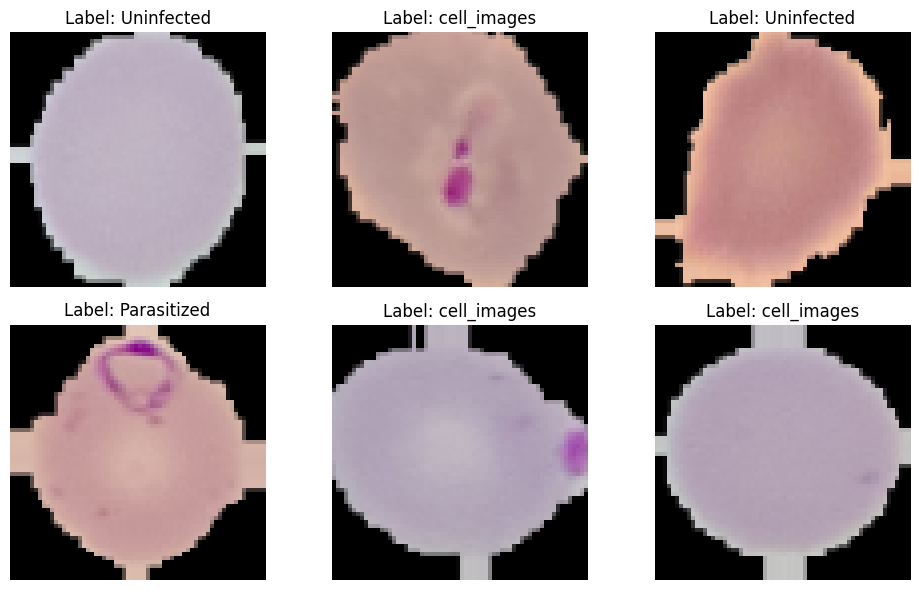

In [ ]:
def plot_sample_images(generator):
    class_labels = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize=(10, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_labels[int(labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.show()




In [ ]:
from tensorflow.keras.models import load_model

# Load the model (make sure the file path is correct)
model = load_model('malaria_model.keras')

In [ ]:
# Save the trained model
model.save('malaria_model.keras')
print("Model saved as malaria_model.keras")

Model saved as malaria_model.keras


# Telegram bot

In [ ]:
# Set your actual BotFather token here
BOT_TOKEN = "7816980046:AAHHW0XonmzZ0M8z4sMP-8zuTra9Ws12aEg"

# Logging
import logging
logging.basicConfig(level=logging.INFO)

from telegram import Update, Bot
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, ContextTypes, filters
import io
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import nest_asyncio

# /start command
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text("👋 Send me a microscope image and I'll predict if it's 🦠 Infected or ✅ Uninfected.")

# Image handler
async def handle_image(update: Update, context: ContextTypes.DEFAULT_TYPE):
    try:
        photo = update.message.photo[-1]
        file = await photo.get_file()
        byte_image = await file.download_as_bytearray()

        # Preprocess image
        img = Image.open(io.BytesIO(byte_image)).resize((64, 64))
        arr = img_to_array(img) / 255.0
        arr = np.expand_dims(arr, axis=0)

        # Prediction
        pred = model.predict(arr)[0][0]
        result = "🦠 Infected" if pred > 0.5 else "✅ Uninfected"
        await update.message.reply_text(f"Prediction: {result}\nConfidence: {pred:.2f}")

    except Exception as e:
        await update.message.reply_text(f"Error: {str(e)}")

# Bot main loop
async def main():
    app = ApplicationBuilder().token(BOT_TOKEN).build()
    app.add_handler(CommandHandler("start", start))
    app.add_handler(MessageHandler(filters.PHOTO, handle_image))
    print("🤖 Bot is running...")
    await app.run_polling()

# Required in Colab
nest_asyncio.apply()
await main()

🤖 Bot is running...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
